In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../raw_data/mbti_1.csv')
df.head(5)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [3]:
import re

def clean_posts(text):
    # Split the tweets on ||||
    tweets = text.split("|||")
    cleaned = []

    for tweet in tweets:
        # Remove mentions
        tweet = re.sub(r'@\w+', '', tweet)
        # Remove URLs
        tweet = re.sub(r'http\S+', '', tweet)
        # Normalize unicode quotes and dashes (optional)
        tweet = tweet.replace('’', "'").replace('“', '"').replace('”', '"')
        # Keep basic punctuation, remove other non-letter characters
        tweet = re.sub(r'[^a-zA-Z0-9\s.,!?\'"]', '', tweet)
        # Remove extra whitespace
        tweet = re.sub(r'\s+', ' ', tweet).strip()
        # Lowercase
        tweet = tweet.lower()
        # Append only if not empty
        if tweet:
            cleaned.append(tweet)

    # Join tweets with a period and line break for readability
    return ". ".join(cleaned)

df['clean_text'] = df['posts'].apply(clean_posts)

In [4]:
custom_stopwords = {
    "intj", "intp", "entj", "entp",
    "infj", "infp", "enfj", "enfp",
    "istj", "isfj", "estj", "esfj",
    "istp", "isfp", "estp", "esfp",
    "intjs", "intps", "entjs", "entps",
    "infjs", "infps", "enfjs", "enfps",
    "istjs", "isfjs", "estjs", "esfjs",
    "istps", "isfps", "estps", "esfps"
}

# Création d'un pattern regex pour supprimer tous les mots MBTI
pattern = r'\b(?:' + '|'.join(re.escape(word) for word in custom_stopwords) + r')\b'

# Suppression dans la colonne 'clean_text' (insensible à la casse)
df['clean_text'] = df['clean_text'].str.replace(pattern, '', flags=re.IGNORECASE, regex=True)

# Suppression des espaces multiples (optionnel pour nettoyer)
df['clean_text'] = df['clean_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [5]:
!pip install langchain --q

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

# Initialize the text splitter: ~350 words ≈ 2000 characters
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,    # chunk_size in characters, not words
    chunk_overlap=300   # to maintain context between chunks
)

# Create a list to hold the split results
split_rows = []

# Loop through each row in the DataFrame
for idx, row in df.iterrows():
    doc = Document(
        page_content=row['clean_text'],
        metadata={'index': idx, 'type': row['type']}  # Store row metadata
    )

    # Split document into chunks
    chunks = text_splitter.split_documents([doc])

    # Append each chunk as a new row, with original metadata
    for i, chunk in enumerate(chunks):
        split_rows.append({
            'original_index': idx,
            'type': row['type'],
            'chunk_id': i,
            'text_chunk': chunk.page_content,
            'text_length_words': len(chunk.page_content.split())
        })

# Create a new DataFrame with the split chunks
df_chunks = pd.DataFrame(split_rows)

In [7]:
df_chunks.head()

,original_index,type,chunk_id,text_chunk,text_length_words
0,0,INFJ,0,'. and moments sportscenter not top ten plays ...,346
1,0,INFJ,1,and even then you verbally fatigue quickly.. i...,279
2,1,ENTP,0,'i'm finding the lack of me in these posts ver...,374
3,1,ENTP,1,you hear about that new first person shooter g...,394
4,1,ENTP,2,a little crush on me. i get red.... tt you jus...,395


In [8]:
df_chunks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37785 entries, 0 to 37784
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_index     37785 non-null  int64 
 1   type               37785 non-null  object
 2   chunk_id           37785 non-null  int64 
 3   text_chunk         37785 non-null  object
 4   text_length_words  37785 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.4+ MB


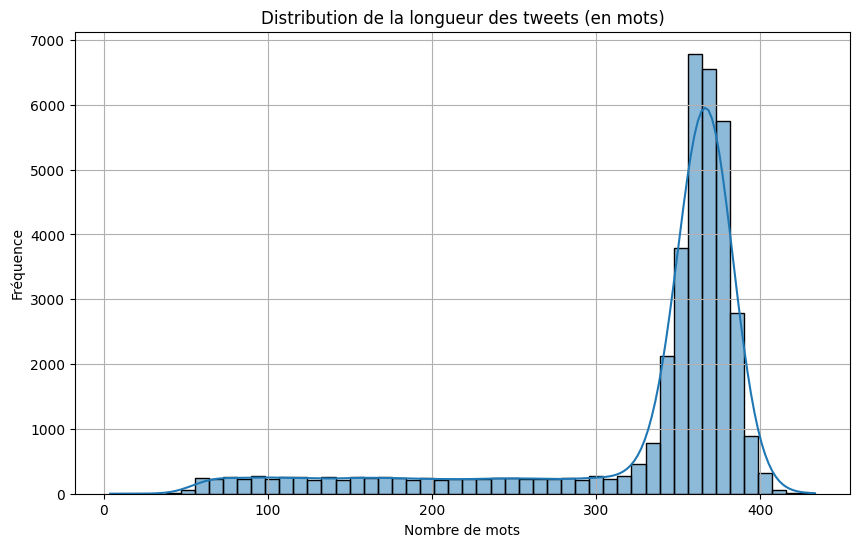

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df_chunks['text_length_words'], bins=50, kde=True)
plt.title("Distribution de la longueur des tweets (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

In [10]:
df_chunks = df_chunks[df_chunks['text_length_words'] > 320]
df_chunks = df_chunks[df_chunks['text_length_words'] < 400]

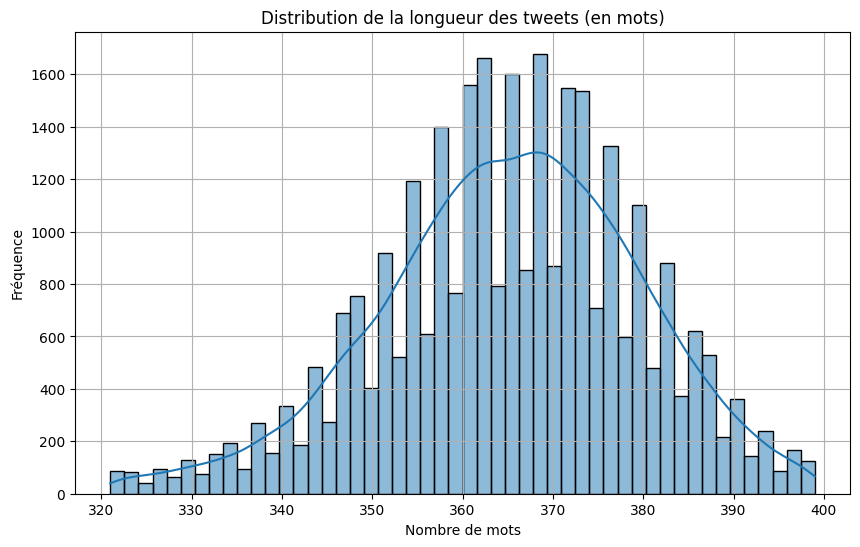

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df_chunks['text_length_words'], bins=50, kde=True)
plt.title("Distribution de la longueur des tweets (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

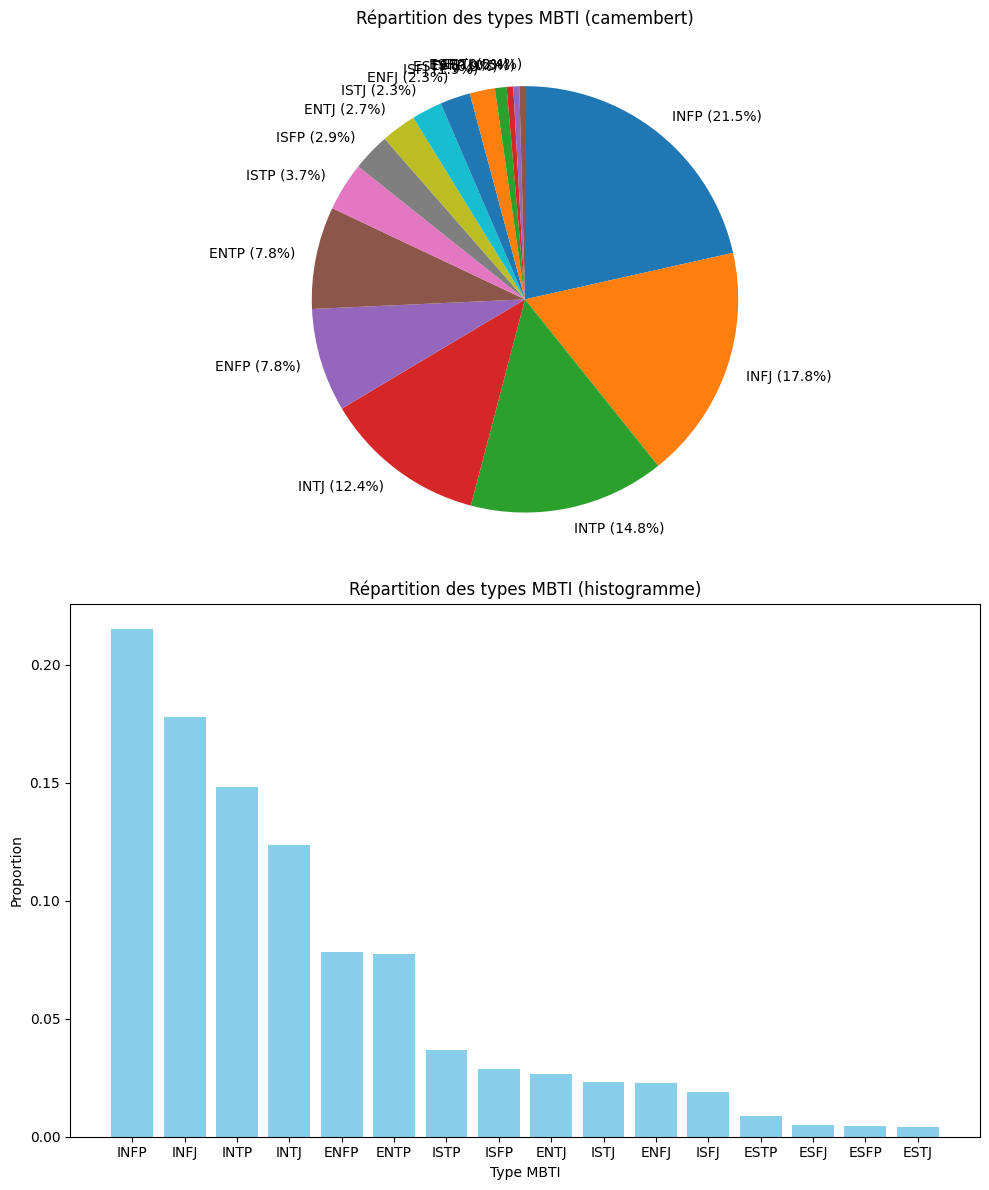

In [12]:
type_distribution = df_chunks['type'].value_counts(normalize=True).sort_values(ascending=False)

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# --- pie plot ---
axes[0].pie(
    type_distribution,
    labels=[f"{t} ({p*100:.1f}%)" for t, p in type_distribution.items()],
    autopct=None,
    startangle=90,
    counterclock=False
)
axes[0].set_title("Répartition des types MBTI (camembert)")

# --- Hist plot ---
axes[1].bar(type_distribution.index, type_distribution.values, color='skyblue')
axes[1].set_title("Répartition des types MBTI (histogramme)")
axes[1].set_ylabel("Proportion")
axes[1].set_xlabel("Type MBTI")

plt.tight_layout()
plt.show()

In [16]:
df_chunks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30017 entries, 0 to 37783
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_index     30017 non-null  int64 
 1   type               30017 non-null  object
 2   chunk_id           30017 non-null  int64 
 3   text_chunk         30017 non-null  object
 4   text_length_words  30017 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.4+ MB


In [17]:
df_chunks['text_chunk'][0]

"'. and moments sportscenter not top ten plays pranks. what has been the most lifechanging experience in your life?. on repeat for most of today.. may the perc experience immerse you.. the last thing my friend posted on his facebook before committing suicide the next day. rest in peace. hello enfj7. sorry to hear of your distress. it's only natural for a relationship to not be perfection all the time in every moment of existence. try to figure the hard times as times of growth, as.... 84389 84390 .... welcome and stuff.. game. set. match.. prozac, wellbrutin, at least thirty minutes of moving your legs and i don't mean moving them while sitting in your same desk chair, weed in moderation maybe try edibles as a healthier alternative.... basically come up with three items you've determined that each type or whichever types you want to do would more than likely use, given each types' cognitive functions and whatnot, when left by.... all things in moderation. sims is indeed a video game, a

In [18]:
# Create one binary column for each MBTI letter
df_chunks['IE'] = df_chunks['type'].apply(lambda x: 1 if x[0] == 'I' else 0)
df_chunks['NS'] = df_chunks['type'].apply(lambda x: 1 if x[1] == 'N' else 0)
df_chunks['TF'] = df_chunks['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df_chunks['JP'] = df_chunks['type'].apply(lambda x: 1 if x[3] == 'J' else 0)

In [19]:
print(f"balance of the target ie : {df_chunks['IE'].value_counts(normalize=True)}")
print(f"balance of the target ns :{df_chunks['NS'].value_counts(normalize=True)}")
print(f"balance of the target tf :{df_chunks['TF'].value_counts(normalize=True)}")
print(f"balance of the target jp :{df_chunks['JP'].value_counts(normalize=True)}")

balance of the target ie : IE
1    0.771996
0    0.228004
Name: proportion, dtype: float64
balance of the target ns :NS
1    0.869774
0    0.130226
Name: proportion, dtype: float64
balance of the target tf :TF
0    0.551121
1    0.448879
Name: proportion, dtype: float64
balance of the target jp :JP
0    0.597961
1    0.402039
Name: proportion, dtype: float64


In [20]:
!pip install xgboost --q

In [23]:
df_chunks.head()

,original_index,type,chunk_id,text_chunk,text_length_words,IE,NS,TF,JP
0,0,INFJ,0,'. and moments sportscenter not top ten plays ...,346,1,1,0,1
2,1,ENTP,0,'i'm finding the lack of me in these posts ver...,374,0,1,1,0
3,1,ENTP,1,you hear about that new first person shooter g...,394,0,1,1,0
4,1,ENTP,2,a little crush on me. i get red.... tt you jus...,395,0,1,1,0
6,2,INTP,0,"'good one. of course, to which i say i know th...",362,1,1,1,0


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [42]:
vectorizer = TfidfVectorizer(max_features=20000,
                             ngram_range=(1, 2),
                             stop_words=list(ENGLISH_STOP_WORDS)
                             )

X = vectorizer.fit_transform(df_chunks["text_chunk"])

In [43]:
y_ie = df_chunks["IE"]
X_train_ie, X_test_ie, y_train_ie, y_test_ie = train_test_split(X, y_ie, test_size=0.2, random_state=42)
model_ie = XGBClassifier(eval_metric='logloss')
model_ie.fit(X_train_ie, y_train_ie)
y_pred_ie = model_ie.predict(X_test_ie)
print(classification_report(y_test_ie, y_pred_ie))

              precision    recall  f1-score   support

           0       0.51      0.10      0.17      1356
           1       0.79      0.97      0.87      4648

    accuracy                           0.77      6004
   macro avg       0.65      0.54      0.52      6004
weighted avg       0.72      0.77      0.71      6004



In [45]:
# Get feature importances
importances_ie = model_ie.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_ie = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_ie = list(zip(feature_names_ie, importances_ie))

# Sort by importance
word_importances_ie = sorted(word_importances_ie, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_ie[:20]:
    print(f"{word}: {importance:.4f}")

7w8: 0.0050
8w7: 0.0041
7w6: 0.0041
neti: 0.0040
ne: 0.0039
haha: 0.0032
introverted extroverts: 0.0029
lol: 0.0029
dear anonymous: 0.0028
hahaha: 0.0028
ambivert: 0.0028
lame: 0.0028
plans: 0.0026
adhd: 0.0026
8w9: 0.0025
nah: 0.0025
figure: 0.0025
boredom: 0.0025
affect: 0.0024
hahah: 0.0024


In [46]:
y_ns = df_chunks["NS"]
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, y_ns, test_size=0.2, random_state=42)
model_ns = XGBClassifier(eval_metric='logloss')
model_ns.fit(X_train_ns, y_train_ns)
y_pred_ns = model_ns.predict(X_test_ns)
print(classification_report(y_test_ns, y_pred_ns))

              precision    recall  f1-score   support

           0       0.58      0.04      0.08       794
           1       0.87      1.00      0.93      5210

    accuracy                           0.87      6004
   macro avg       0.73      0.52      0.51      6004
weighted avg       0.83      0.87      0.82      6004



In [47]:
# Get feature importances
importances_ns = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_ns = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_ns = list(zip(feature_names_ns, importances_ns))

# Sort by importance
word_importances_ns = sorted(word_importances_ns, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_ns[:20]:
    print(f"{word}: {importance:.4f}")

rave: 0.0065
stressful: 0.0046
inferior ne: 0.0042
niss: 0.0038
biking: 0.0038
fixing: 0.0038
sela: 0.0037
human: 0.0034
clique: 0.0034
little things: 0.0033
tini: 0.0031
se: 0.0031
divorce: 0.0030
car: 0.0029
hobbies: 0.0029
sport: 0.0028
don like: 0.0028
drives: 0.0028
sj: 0.0028
johnson: 0.0027


In [48]:
y_tf = df_chunks["TF"]
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, y_tf, test_size=0.2, random_state=42)
model_tf = XGBClassifier(eval_metric='logloss')
model_tf.fit(X_train_tf, y_train_tf)
y_pred_tf = model_tf.predict(X_test_tf)
print(classification_report(y_test_tf, y_pred_tf))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      3303
           1       0.68      0.62      0.65      2701

    accuracy                           0.70      6004
   macro avg       0.70      0.69      0.69      6004
weighted avg       0.70      0.70      0.70      6004



In [49]:
# Get feature importances
importances_tf = model_tf.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_tf = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_tf = list(zip(feature_names_tf, importances_tf))

# Sort by importance
word_importances_tf = sorted(word_importances_tf, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_tf[:20]:
    print(f"{word}: {importance:.4f}")

feel: 0.0051
physics: 0.0042
beautiful: 0.0041
heart: 0.0040
rational: 0.0038
lately: 0.0036
happy: 0.0035
dream: 0.0034
requires: 0.0032
fucking: 0.0032
ti: 0.0032
knowledge: 0.0031
love: 0.0031
dreams: 0.0030
sensitive: 0.0030
wonderful: 0.0029
shy: 0.0029
felt: 0.0028
hi: 0.0028
intelligence: 0.0027


In [50]:
y_jp = df_chunks["JP"]
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X, y_jp, test_size=0.2, random_state=42)
model_jp = XGBClassifier(eval_metric='logloss')
model_jp.fit(X_train_jp, y_train_jp)
y_pred_jp = model_jp.predict(X_test_jp)
print(classification_report(y_test_jp, y_pred_jp))

              precision    recall  f1-score   support

           0       0.64      0.82      0.72      3598
           1       0.54      0.32      0.40      2406

    accuracy                           0.62      6004
   macro avg       0.59      0.57      0.56      6004
weighted avg       0.60      0.62      0.59      6004



In [51]:
# Get feature importances
importances_jp = model_jp.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_jp = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_jp = list(zip(feature_names_jp, importances_jp))

# Sort by importance
word_importances_jp = sorted(word_importances_jp, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_jp[:20]:
    print(f"{word}: {importance:.4f}")

ni: 0.0050
affirmation: 0.0037
fuck: 0.0035
inferior se: 0.0032
weed: 0.0031
ne: 0.0031
niti: 0.0029
doorslam: 0.0028
half: 0.0025
observation: 0.0025
plan: 0.0025
friendship: 0.0025
7w8: 0.0025
creative: 0.0025
typing: 0.0023
rave: 0.0023
medical: 0.0023
cautious: 0.0023
6w5: 0.0023
dear: 0.0022


In [52]:
ie_pred = ['i' if x == 1 else 'e' for x in y_pred_ie]
ns_pred = ['n' if x == 1 else 's' for x in y_pred_ns]
tf_pred = ['t' if x == 1 else 'f' for x in y_pred_tf]
jp_pred = ['j' if x == 1 else 'p' for x in y_pred_jp]

y_test_ie_l = ['i' if x == 1 else 'e' for x in y_test_ie]
y_test_ns_l = ['n' if x == 1 else 's' for x in y_test_ns]
y_test_tf_l = ['t' if x == 1 else 'f' for x in y_test_tf]
y_test_jp_l = ['j' if x == 1 else 'p' for x in y_test_jp]

In [53]:
# Create DataFrame
df_pred = pd.DataFrame({
    'IE': ie_pred,
    'NS': ns_pred,
    'TF': tf_pred,
    'JP': jp_pred,
    'IE_test': y_test_ie_l,
    'NS_test': y_test_ns_l,
    'TF_test': y_test_tf_l,
    'JP_test': y_test_jp_l
})

df_pred['MBTI'] = df_pred['IE'] + df_pred['NS'] + df_pred['TF'] + df_pred['JP']
df_pred['MBTI_test'] = df_pred['IE_test'] + df_pred['NS_test'] + df_pred['TF_test'] + df_pred['JP_test']

In [54]:
df_pred

,IE,NS,TF,JP,IE_test,NS_test,TF_test,JP_test,MBTI,MBTI_test
0,i,n,f,p,i,n,t,j,infp,intj
1,i,n,t,p,e,s,t,j,intp,estj
2,i,n,f,j,i,n,f,j,infj,infj
3,i,n,f,p,i,s,f,p,infp,isfp
4,i,n,f,p,i,n,f,j,infp,infj
...,...,...,...,...,...,...,...,...,...,...
5999,i,n,t,p,i,n,f,j,intp,infj
6000,i,n,t,p,i,s,t,p,intp,istp
6001,i,n,f,j,i,n,f,j,infj,infj
6002,i,n,f,p,e,n,t,p,infp,entp


In [55]:
accuracy = (df_pred['MBTI'] == df_pred['MBTI_test']).mean() * 100

print(f"Pourcentage de MBTI correctement prédits : {accuracy:.2f}%")

Pourcentage de MBTI correctement prédits : 28.56%


In [56]:
accuracy_ie = (df_pred['IE'] == df_pred['IE_test']).mean() * 100
accuracy_ns = (df_pred['NS'] == df_pred['NS_test']).mean() * 100
accuracy_tf = (df_pred['TF'] == df_pred['TF_test']).mean() * 100
accuracy_jp = (df_pred['JP'] == df_pred['JP_test']).mean() * 100


print(f"Pourcentage de IE correctement prédits : {accuracy_ie:.2f}%")
print(f"Pourcentage de NS correctement prédits : {accuracy_ns:.2f}%")
print(f"Pourcentage de TF correctement prédits : {accuracy_tf:.2f}%")
print(f"Pourcentage de JP correctement prédits : {accuracy_jp:.2f}%")

Pourcentage de IE correctement prédits : 77.48%
Pourcentage de NS correctement prédits : 86.94%
Pourcentage de TF correctement prédits : 69.85%
Pourcentage de JP correctement prédits : 61.88%
